# Evaluation of CNN classification performance

In [1]:
muonic = False
hadronic = not muonic

In [2]:
import numpy as np

In [3]:
import tensorflow as tf

2025-01-29 13:32:01.692934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 13:32:01.726164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738153921.752962   75862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738153921.761273   75862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 13:32:01.792173: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
le = LabelEncoder()

In [6]:
from preprocessing import reshape_data

In [7]:
import uproot

In [11]:
import matplotlib.pyplot as plt

# plt.style.use(["science", "notebook"])

In [12]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.formatter.limits"] = -5, 4
plt.rcParams["figure.figsize"] = 6, 4
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [13]:
filename_test = "df_nu_CC_muonic_equal_test.root:df"

In [14]:
events_test = uproot.open(filename_test)

In [15]:
target = "nu_flavour"

target_pretty = "flavour"
target_LaTeX = "flavour"

In [16]:
events_test[target].num_entries

1865

In [17]:
y = np.abs(events_test[target])

In [18]:
le.fit(y)

LabelEncoder()

In [19]:
le.classes_

array([14, 16])

In [20]:
def event_generator():
    events = events_test
    for batch, report in events.iterate(step_size=1, report=True, library="np"):
        ys = le.transform(np.abs(batch[target]))
        for i in range(batch["X"].shape[0]):
            yield (
                batch["X"].astype(np.float16)[i],
                batch["X_mufilter"].astype(np.float16)[i],
                ys[i],
            )

In [21]:
gen = event_generator()

In [22]:
sample = gen.__next__()

In [23]:
generator_spec_0 = tf.type_spec_from_value(gen.__next__()[0])
generator_spec_1 = tf.type_spec_from_value(gen.__next__()[1])
generator_spec_2 = tf.type_spec_from_value(gen.__next__()[2])

I0000 00:00:1738153932.197589   75862 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1479 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:07.0, compute capability: 7.5


In [24]:
print(generator_spec_0)

TensorSpec(shape=(3279, 116), dtype=tf.float16, name=None)


In [25]:
print(generator_spec_1)

TensorSpec(shape=(3279, 68), dtype=tf.float16, name=None)


In [26]:
print(generator_spec_2)

TensorSpec(shape=(), dtype=tf.int64, name=None)


In [27]:
ds_test = (
    tf.data.Dataset.from_generator(
        event_generator,
        output_signature=(
            generator_spec_0,
            generator_spec_1,
            generator_spec_2,
        ),
    )
    .map(reshape_data)
    .apply(tf.data.experimental.assert_cardinality(events_test.num_entries))
)

In [28]:
y_test = le.transform(np.abs(events_test[target]))

In [29]:
np.count_nonzero(y_test)

779

In [30]:
batched_ds_test = ds_test.batch(30)

In [31]:
from tensorflow.keras.models import load_model

In [32]:
import tensorflow.keras.backend as K

K.set_image_data_format("channels_last")

In [33]:
model = load_model("CNN_nuflav_muonic_grandjorasses_nu_flavour_n12227_e200.keras")

In [34]:
model_name = model.name

In [35]:
# test=retoy_model.predict(x=[x_test['scifi_h'], x_test['scifi_v'], x_test['us'], x_test['ds']])
y_pred = model.predict(batched_ds_test)

2025-01-29 13:32:14.948119: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Mon/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['target_h_in', 'target_v_in', 'mufilter_h_in', 'mufilter_v_in']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(
I0000 00:00:1738153937.045300   75961 service.cc:148] XLA service 0x7f1d54005e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738153937.045358   75961 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-29 13:32:17.076798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` t

 3/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step

I0000 00:00:1738153941.377348   75961 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step

/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Mon/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['target_h_in', 'target_v_in', 'mufilter_h_in', 'mufilter_v_in']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(
2025-01-29 13:33:02.819167: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[5,16,29,819]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,16,29,819]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-29 13:33:02.864155: I 

63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 690ms/step


In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
from config import nu_mu_yield, nu_tau_yield, nu_e_yield, frac_muon, frac_hadr

In [38]:
scaling_muon = np.array([nu_mu_yield, nu_tau_yield * frac_muon]).reshape(-1, 1)

In [39]:
scaling_hadr = np.array([nu_e_yield, nu_tau_yield * frac_hadr]).reshape(-1, 1)

In [40]:
def metric(threshold=0.5):
    TN, FP, FN, TP = confusion_matrix(y_test, (y_pred >= threshold).astype(int)).ravel()
    signal = TP / (TP + FN) * nu_tau_yield * (frac_muon if muonic else frac_hadr)
    background = FP / (FP + TN) * (nu_mu_yield if muonic else nu_e_yield)
    return -signal / np.sqrt(signal + background)

In [41]:
from scipy.optimize import basinhopping

In [42]:
res = basinhopping(metric, 0.2)

/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal + background)
/tmp/ipykernel_75862/1823911924.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return -signal / np.sqrt(signal

In [43]:
optimum_threshold = res.x[0]

In [44]:
optimum_threshold = 0.5

In [45]:
y_pred_bool = (y_pred >= optimum_threshold).astype(int)

(array([1086.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         779.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

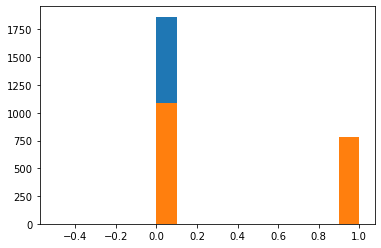

In [46]:
# plt.hist(y_pred_bool)
plt.hist(y_pred_bool)
plt.hist(y_test)

In [47]:
print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       0.58      1.00      0.74      1086
           1       0.00      0.00      0.00       779

    accuracy                           0.58      1865
   macro avg       0.29      0.50      0.37      1865
weighted avg       0.34      0.58      0.43      1865



/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Mon/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Mon/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev3cuda/Mon/x86_64-el9-gcc11-opt/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s

In [48]:
from sklearn.metrics import ConfusionMatrixDisplay

Text(0.785, 1.02, 'AdvSND')

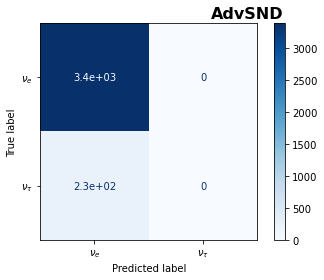

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
# Plot non-normalized confusion matrix
titles_options = [
    # ("Confusion matrix, without normalisation", None),
    # ("Normalised confusion matrix", "true"),
    ("Scaled confusion matrix", "scaled"),
]
for title, normalize in titles_options:
    scale = 1.0
    if normalize == "scaled":
        normalize = "true"
        scale = scaling_hadr if hadronic else scaling_muon
    disp = ConfusionMatrixDisplay(
        confusion_matrix(
            le.inverse_transform(y_test.ravel()),
            le.inverse_transform(y_pred_bool.ravel()),
            normalize=normalize,
        )
        * scale,
        display_labels=[r"$\nu_e$", r"$\nu_\tau$"],
    )
    disp.plot(cmap=plt.cm.Blues, ax=ax)

    # disp.plot(ax=ax)
    # disp.ax_.set_title(title)

    # print(title)
    # print(disp.confusion_matrix)

plt.text(
    0.785,
    1.02,
    "AdvSND",
    fontweight="bold",
    fontfamily="sans-serif",
    fontsize=16,
    transform=ax.transAxes,
    usetex=False,
)

# plt.show()
#plt.savefig(f"plots/confusion_matrix_{model_name}_n{n_events}_e{len(history_df)}.png")
#plt.savefig(f"plots/confusion_matrix_{model_name}_n{n_events}_e{len(history_df)}.pdf")

In [50]:
from sklearn.metrics import RocCurveDisplay

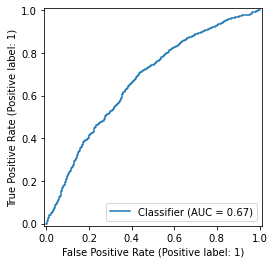

In [51]:
RocCurveDisplay.from_predictions(y_test, y_pred)